## Importing all necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

#### Importing dataset

In [5]:
df = pd.read_csv('winequality.csv')

In [6]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### Data Wrangling:
Check how many missing values we have in total in this dataset.

In [7]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

#### Data Exploration:
Since this dataset consists of 12 features of red wine, there might be strong correlations between features. I am particularly interested in the correlation of “quality” with other features such as “alcohol”, “pH”, or “acidity”. Let’s plot a correlation matrix to see all the correlations between features in a quick glimpse.

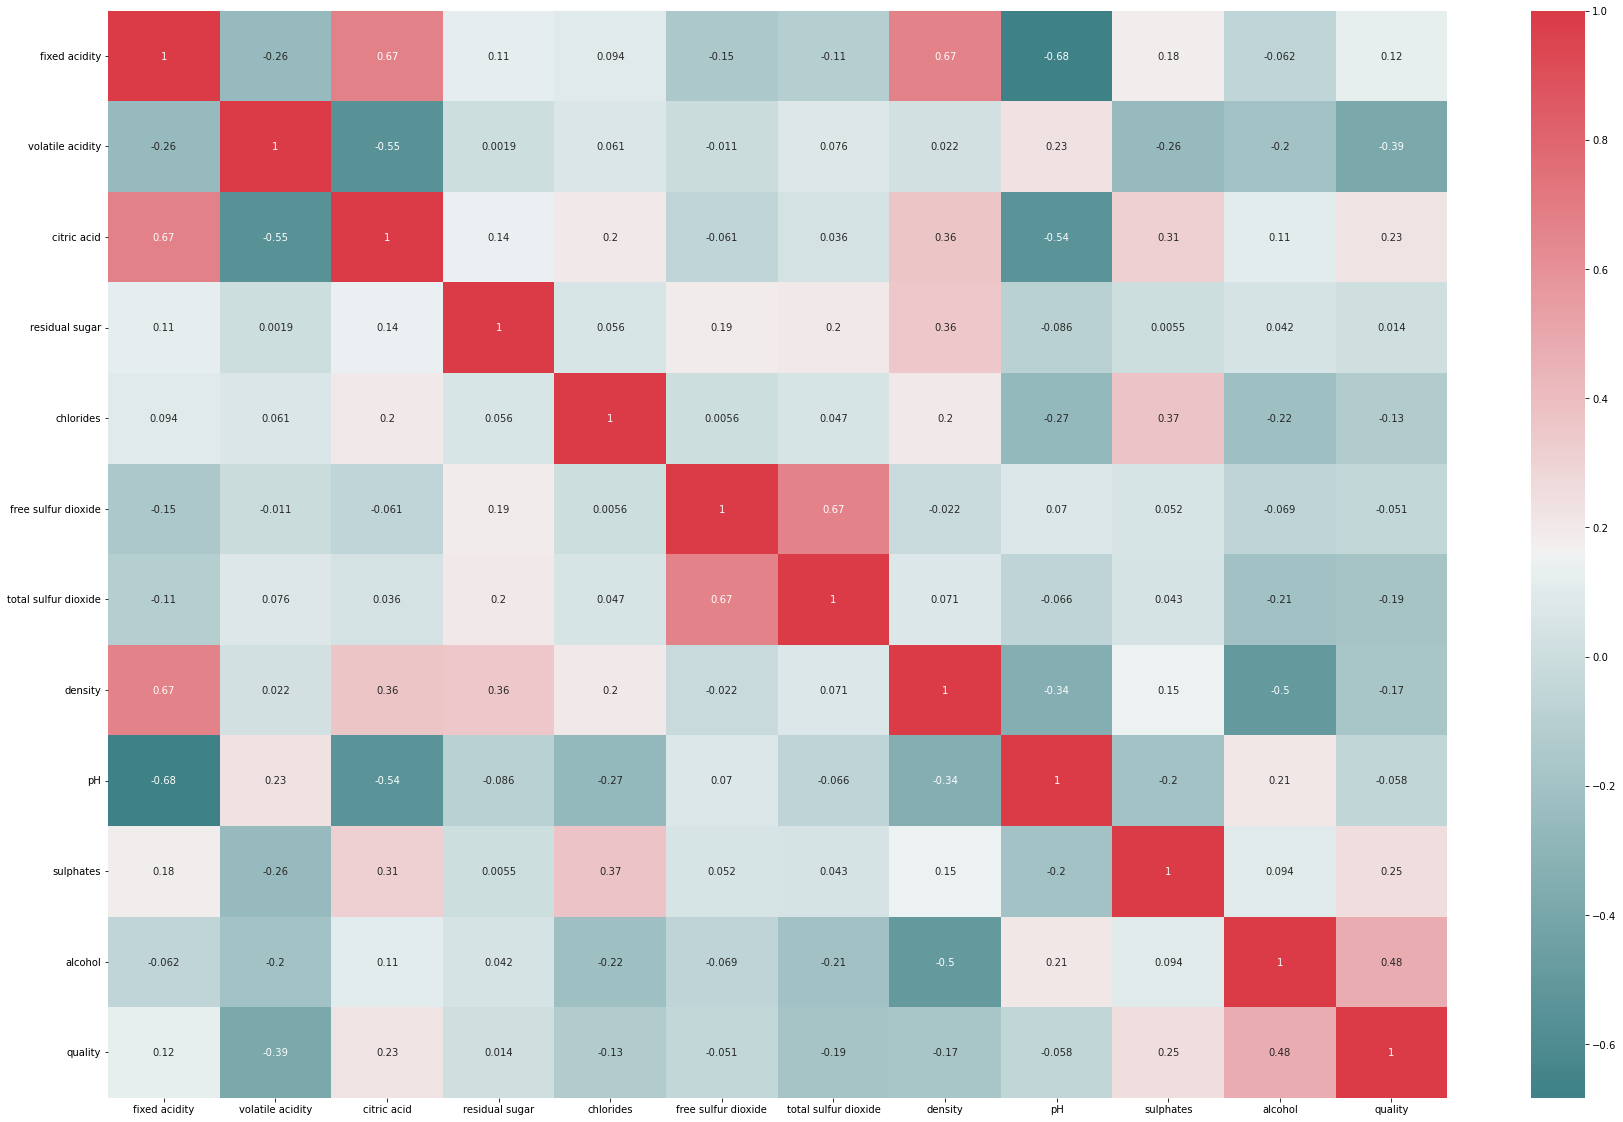

In [8]:
plt.figure(figsize=(30,20))
corr = df.corr()
sns.heatmap(corr,annot=True,cmap=sns.diverging_palette(200, 10, as_cmap=True))
plt.show()

From the graph, we can see that alcohol is most strongly correlated with quality, and the correlation is positive. Let’s dive deeper to see the variations in alcohol levels for wines of different qualities using a bar graph.

No handles with labels found to put in legend.


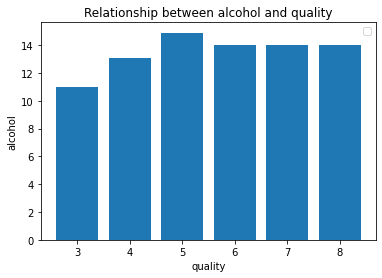

In [10]:
plt.bar(df['quality'], df['alcohol'])
plt.title('Relationship between alcohol and quality')
plt.xlabel('quality')
plt.ylabel('alcohol')
plt.legend()
plt.show()

Immediately, we know that wines of lower quality tend to have a lower level of alcohol. However, correlation does not indicate a causal relationship. Thus, I want to further investigate the top 3 important properties that can make a wine good (high quality). This investigation requires the use of classification models because the top 3 important properties can classify wines into “good” or “regular” labels.

#### Prepare the Data for Classification Model:
Because the predictive outcomes need to be either “good wine” or “not,” classification models are necessary to use for this problem. Before fitting the data into classification models, Let’s first do some preprocessing to prepare the data.

I first normalize the dataset. Normalizing the data will transform the data so that its distribution has a uniform range. It’s important to equalize the ranges of the data here because in our dataset citric acid and volatile acidity, for example, have all of their values between 0 and 1. In contrast, total sulfur dioxide has some values over 100 and some values below 10. This disparity in ranges may cause a problem since a small change in a feature might not affect the other. To address this problem, I normalize the ranges of the dataset to a uniform range between 0 and 1.

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
normal_df = scaler.fit_transform(df)
normal_df = pd.DataFrame(normal_df, columns = df.columns)
print(normal_df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.247788          0.397260         0.00        0.068493   0.106845   
1       0.283186          0.520548         0.00        0.116438   0.143573   
2       0.283186          0.438356         0.04        0.095890   0.133556   
3       0.584071          0.109589         0.56        0.068493   0.105175   
4       0.247788          0.397260         0.00        0.068493   0.106845   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.140845              0.098940  0.567548  0.606299   0.137725   
1             0.338028              0.215548  0.494126  0.362205   0.209581   
2             0.197183              0.169611  0.508811  0.409449   0.191617   
3             0.225352              0.190813  0.582232  0.330709   0.149701   
4             0.140845              0.098940  0.567548  0.606299   0.137725   

    alcohol  quality  
0  0.153846      0.4  
1  0.21538

Next, to make the classification outcomes a bit more direct, I create a new column named “good wine” in the original dataset df. “Good wine” equals “yes” when the quality is equal or above 7. “Good wine” equals “no” when the quality is less than 7. Classification models will finally output “yes” or “no” to predict wine quality.

In [12]:
df["good wine"] = ["yes" if i >= 7 else "no" for i in df['quality']]

Create features X and target variable y. X is all the features from the normalized dataset except “quality”. y is the newly created “good wine” variable from the original dataset df.

In [13]:
X = normal_df.drop(["quality"], axis = 1)
y = df["good wine"]

Finally, I want to make sure there is enough “good wine” exists in y.

In [14]:
y.value_counts()

no     1382
yes     217
Name: good wine, dtype: int64

Visualize the counts

C:\Users\Rambabu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


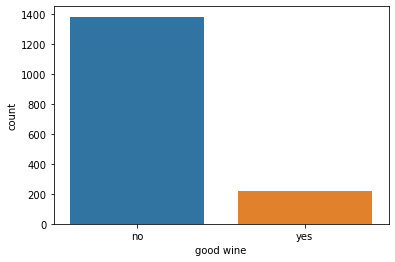

In [15]:
sns.countplot(y)
plt.show()

The result is a bit imbalanced but fair enough. We have over 200 good wines. When we partition our data into the training set and testing set, don’t forget to use stratify = y to ensure the training and testing set have the same portion of “yes” and “no” as the original dataset.

#### Modeling:
Partition X and y into training and testing dataset. Remember to use stratify = y to retain the original proportion of “yes” and “no.”

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020, stratify=y)

##### Baseline Classification:
Let’s first create a baseline classification model to serve as a benchmark in future comparisons.

I use DummyClassifier from sklearn and choose the strategy as “most frequent,” which means the model will always predict the most frequent label in the training set. In other words, this model will always output “no” as its prediction. The accuracy score is 0.86, which is just the proportion of the “no” label in the data.

In [17]:
from sklearn.dummy import DummyClassifier
dummy_classifier = DummyClassifier(strategy='most_frequent',random_state=2020)
dummy_classifier.fit(X_train,y_train)
acc_baseline = dummy_classifier.score(X_test,y_test)
print("Baseline Accuracy = ", acc_baseline)

Baseline Accuracy =  0.8645833333333334


#### Model One: Support Vector Classifier
“ SVM is a supervised machine learning algorithm that is powerful for classification problems. It relies on a technique named kernel to transform the data, and based on the transformation, it finds an optimal way to separate the data according to the labels.”

#### 1. Fit, Predict, and Accuracy Score:
Let’s fit the training data to an SVM model.

In [18]:
from sklearn.svm import SVC
svc = SVC(random_state=2020)
svc.fit(X_train, y_train)

SVC(random_state=2020)

Next, predict the outcomes for the test set and print its accuracy score.

In [19]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
y_pred = svc.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8854166666666666


The accuracy score (0.88) of an SVM model is higher than the baseline accuracy (0.86).

#### 2. Overfitting:
Overfitting occurs when the model does very well on the training data while performs poorly on out-of-training data. To detect overfitting, we can compare the accuracy score on training set and the accuracy score on out-of-training set to see if a huge disparity exists.

However, in our case here, since the wine dataset is relatively small (only 1599 entries), I use cross validation to avoid wasting a large part of the data to validate and test.

#### Cross Validation (CV) estimates the generalized performance using the same data as is used to train the model. The idea behind cross-validation is to split the dataset up into a certain number of subsets, and then use each of these subsets as held out test sets in turn while using the rest of the data to train the model.

Use cross_val_score function to estimate the expected accuracy of the model on out-of-training data.

In [20]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svc, X, y, cv=5)
print(scores.mean())

0.8642927115987462


Accuracy score on training data

In [21]:
y_pred_train = svc.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))

0.8927613941018767


Since the training accuracy (0.89) and the cross validation score (0.86) are close, we can conclude that no overfitting occurs.

#### 3. Tune the Model’s Parameters:
To increase the performance of our SVM model, let’s try to tune the model’s following parameters:

C: regularization parameter.

kernel: ‘linear,’ ‘poly,’ ‘rbf.’

First, use RandomizedSearchCV to try out a wide range of values [0.001,0.01,0.1,1,10,100,1000] for C. RandomizedSearchCV allowes us to narrow down the range for C.

In [22]:
from sklearn.model_selection import RandomizedSearchCV
random_grid = {"C": [0.001,0.01,0.1,1,10,100,1000]}
svc_random = RandomizedSearchCV(svc,random_grid,cv=5,random_state=2020)
svc_random.fit(X_train, y_train)
print(svc_random.best_params_)

C:\Users\Rambabu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'C': 1}


Now, we have determined that C should be a value around 1. Move on to use GridSearchCV to do an exhaustive search on C within a range around 1, specifically, the range between 0.8 and 1.4 inclusively.

In [23]:
from sklearn.model_selection import GridSearchCV
param_dist = {'C': [0.8,0.9,1,1.1,1.2,1.3,1.4],
              'kernel':['linear', 'rbf','poly']}
svc_cv = GridSearchCV(svc, param_dist, cv=10)
svc_cv.fit(X_train,y_train)
print(svc_cv.best_params_)

{'C': 1.3, 'kernel': 'rbf'}


GridSearchCV helps us find the best parameters: C = 1.3, kernel = rbf. Let’s use the best parameters given to train a new SVM model.

In [24]:
svc_new = SVC(C = 1.3, kernel = "rbf", random_state = 2020)
svc_new.fit(X_train, y_train)
y_pred_new = svc_new.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_new))

0.89375


By tuning the hyperparameters, the performance of the SVM model increase from 0.885 to 0.894.